<a href="https://colab.research.google.com/github/sarthak-dasgupta0812/End-to-End-Scanpy-Workflow-for-Drosophila-melanogaster-Single-Cell-RNA-seq/blob/main/Scanpy_Drosophila_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q scanpy anndata umap-learn igraph leidenalg scrublet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 87.5 MB/s eta 0:00:00


In [2]:
from __future__ import annotations

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=80, facecolor="white")


/tmp/ipython-input-1766997193.py:9: FutureWarning: Use `scanpy.set_figure_params` instead
  sc.settings.set_figure_params(dpi=80, facecolor="white")


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!mkdir -p /content/drive/MyDrive/scanpy_scrna_drosophila


In [5]:
!ls /content

drive  sample_data


In [6]:
!mv /content/*.gz /content/drive/MyDrive/scanpy_scrna_drosophila/


mv: cannot stat '/content/*.gz': No such file or directory


In [7]:
!ls /content/drive/MyDrive/scanpy_scrna_drosophila


Drosophila_melanogaster.BDGP6.54.62.gtf.gz
full_marker_table_drosophila.csv
GSM3585574_SV_1_10X_Te.barcodes.tsv.gz
GSM3585574_SV_1_10X_Te.features.tsv.gz
GSM3585574_SV_1_10X_Te.matrix.mtx.gz
top_marker_gene_per_leiden_cluster.csv


In [8]:
import scanpy as sc
import pandas as pd

# Load matrix (transpose because MTX is genes × cells)
adata = sc.read_mtx(
    "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.matrix.mtx.gz"
).T

# Load features (genes)
features = pd.read_csv(
    "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.features.tsv.gz",
    sep="\t",
    header=None
)

# Load barcodes (cells)
barcodes = pd.read_csv(
    "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.barcodes.tsv.gz",
    sep="\t",
    header=None
)

# Assign names
adata.var_names = features[1].values   # gene symbols
adata.obs_names = barcodes[0].values   # cell barcodes

# Ensure uniqueness
adata.var_names_make_unique()

adata


AnnData object with n_obs × n_vars = 3000 × 17473

In [9]:
adata.obs_names[:5]   # first 5 cells
adata.var_names[:5]   # first 5 genes
adata.X.shape         # matrix dimensions


(3000, 17473)

In [10]:
#quality control
# Mark mitochondrial genes (Drosophila: "mt:")
adata.var["mt"] = adata.var_names.str.startswith("mt:")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)


In [11]:
adata.var.head()


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
FBgn0031081,False,25,0.008667,99.166667,26.0
FBgn0052826,False,0,0.000000,100.000000,0.0
FBgn0031085,False,412,0.363000,86.266667,1089.0
FBgn0062565,False,0,0.000000,100.000000,0.0
FBgn0031088,False,1,0.000333,99.966667,1.0


In [12]:
adata.var["mt"].sum()


np.int64(0)

In [13]:
features.head()


,0,1
0,FBgn0031081,FBgn0031081
1,FBgn0052826,FBgn0052826
2,FBgn0031085,FBgn0031085
3,FBgn0062565,FBgn0062565
4,FBgn0031088,FBgn0031088


In [14]:
adata.var["gene_ids"] = features[0].values
adata.var["gene_symbols"] = features[1].values

adata.var_names = adata.var["gene_symbols"]
adata.var_names_make_unique()


In [15]:
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)


In [16]:
adata.shape
adata.obs_names[:5]
adata.var_names[:5]
"Act5C" in adata.var_names  # Drosophila housekeeping gene


False

In [17]:
adata.shape
adata.obs_names[:5]
adata.var_names[:5]
"RPL32" in adata.var_names  # Drosophila housekeeping gene

False

In [18]:
# QC filtering
# Remove low-quality cells with very low gene complexity
# Cells expressing fewer than 200 genes are likely empty droplets or dead cells
sc.pp.filter_cells(adata, min_genes=200)

# Remove genes that are expressed in very few cells
# Genes detected in fewer than 3 cells are uninformative and add noise
sc.pp.filter_genes(adata, min_cells=3)


In [19]:
# Check dataset dimensions after QC filtering (whether it worked or not )
adata.shape


(2811, 11969)

In [20]:
# Normalization
# Normalize counts so that each cell has the same total expression
# This removes sequencing depth differences between cells
sc.pp.normalize_total(adata, target_sum=1e4)



In [21]:
# verfication
# sequencing depth is equalized
# Sum of expression per cell after normalization
adata.X.sum(axis=1)[:10]    # every cell has a count of about 10,000 total counts , every cell has been sclaed to 10k


matrix([[10000.001],
        [ 9999.999],
        [ 9999.999],
        [10000.   ],
        [10000.   ],
        [10000.   ],
        [10000.   ],
        [10000.   ],
        [10000.   ],
        [10000.001]], dtype=float32)

In [22]:
# Freeze Raw normalized counts
adata.raw = adata.copy()


In [23]:
# basic check of the count being freezed - raw data is succesfully frozen
adata.raw


In [24]:
# now checkin the dimension
adata.raw.shape


(2811, 11969)

In [25]:
# Log-transform the data to stabilize variance and reduce dominance of highly expressed genes (ribosomal )
# This makes gene expression more comparable across the dynamic range ,  Applies log(1 + x) to compress large values and stabilize variance
# The data was previously log-transformed using sc.pp.log1p(adata).
# Scanpy stores this operation in adata.uns["log1p"], which prevents accidental reapplication.
sc.pp.log1p(adata)

In [26]:
adata.uns.get("log1p")
# Stores metadata indicating whether log1p transformation has been applied
# 'base: None' confirms natural log was used and prevents accidental reapplication


{'base': None}

In [27]:
adata.X.min(), adata.X.max()
# Checks the range of expression values after log transformation
# Values between ~0 and 5–10 confirm successful log1p normalization suitable for PCA



(np.float32(0.0), np.float32(7.8332725))

In [28]:
# Highly variable genes
# Identify genes whose expression varies more than expected across cells
# Selects the top 2,000 most informative genes to drive PCA and downstream clustering
# Uses the Seurat mean–variance model to identify genes with excess biological variability . This method corrects for expression-level bias and is a robust standard for scRNA-seq
# inplace returns true means that stores HVG annotations directly inside the AnnData object  without creating a separate output

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat",
    inplace=True
)


In [29]:
# Check whether RPL32 was selected as a highly variable gene , RPL32 is a ribosomal housekeeping gene , It is often NOT highly variable and this HVG selection is NOT for gene-of-interest analysis so returns false
"RPL32" in adata.var_names


False

In [30]:
# Number of highly variable genes selected - verify
adata.var["highly_variable"].sum()


np.int64(2000)

In [31]:
# Inspect HVG-related columns
adata.var.columns


Index(['mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts',
       'total_counts', 'gene_ids', 'gene_symbols', 'n_cells',
       'highly_variable', 'means', 'dispersions', 'dispersions_norm'],
      dtype='object')

In [32]:
#Peek at HVG stats for a few genes
adata.var[["means", "dispersions", "dispersions_norm", "highly_variable"]].head()
# Genes with high normalized dispersion (dispersions_norm) are marked True.
# Genes with low variability (like housekeeping genes)

,means,dispersions,dispersions_norm,highly_variable
gene_symbols,,,,
FBgn0031081,0.019043,1.262574,-0.950600,False
FBgn0031085,0.889168,2.611907,0.999377,True
FBgn0040784,0.628194,2.606665,0.977298,True
FBgn0031086,0.000486,-0.756024,-3.914955,False
FBgn0031082,0.325842,2.503464,1.164566,True


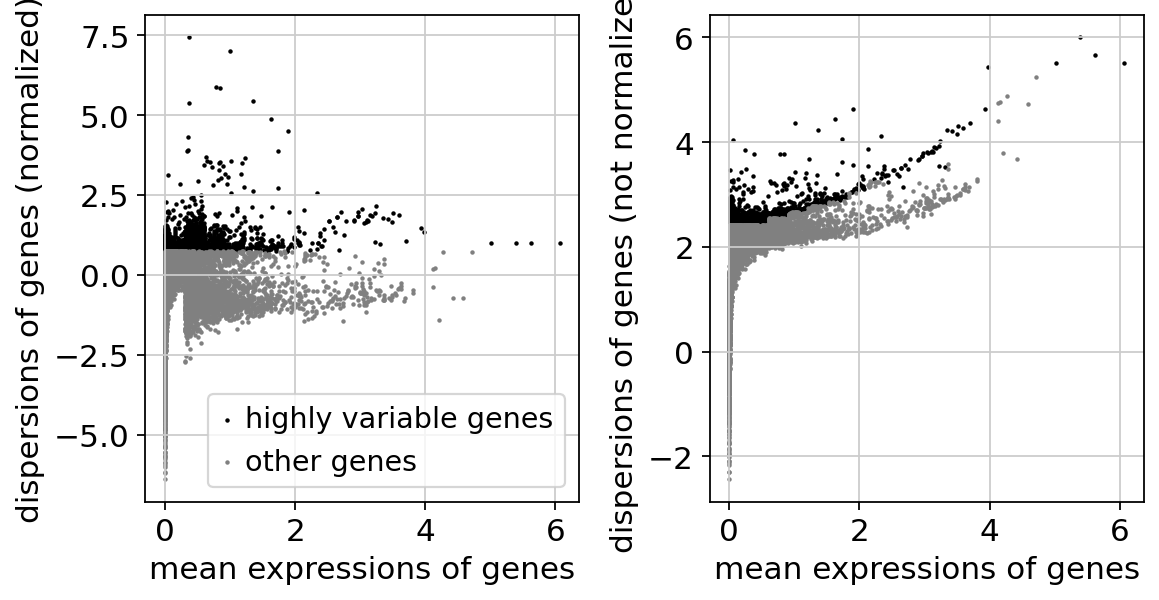

In [33]:
sc.pl.highly_variable_genes(adata)
# Left panel: Normalized dispersions vs mean expression
#Black dots → HVGs ,Grey dots → other genes ,Shows which genes have high variability relative to their mean expression.

# Right panel: Raw dispersions vs mean expression , Shows the original variance before normalization.


In [34]:
#Subset to HVGs ,This ensures PCA, clustering, and neighbors focus only on the genes that matter for heterogeneity.
adata = adata[:, adata.var["highly_variable"]]


In [35]:
# Scaling the HVGs before PCA  - Scales each gene to zero mean, unit variance

# Prepares the data so PCA isn’t dominated by a few highly expressed genes.
sc.pp.scale(adata, max_value=10)
# Scaling needs a full copy, so Scanpy automatically made one.
# data is sparse (mostly zeros, like single-cell RNA-seq counts).Zero-centering (subtracting the mean) requires converting it to a dense array because sparse arrays can’t represent negative numbers efficiently.

/usr/lib/python3.12/functools.py:912: UserWarning: Received a view of an AnnData. Making a copy.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [36]:
np.mean(adata.X, axis=0)  # close to 0 for each gene



array([ 1.14892877e-16,  2.25954675e-16, -1.92896807e-16, ...,
       -2.21017718e-16, -3.86662519e-17,  5.98754217e-16])

In [37]:
np.std(adata.X, axis=0)   # close to 1 for each gene

array([0.99982211, 0.99982211, 0.99982211, ..., 0.99982211, 0.99982211,
       0.99982211])

In [38]:
# PCA - principal component  analysis  - svd_solver='arpack' ,
# PCA is mathematically based on Singular Value Decomposition (SVD).
# arpack is one of the algorithms  for computation
# Good for large datasets, when you only need the first few PCs (default: 50).

# Run PCA on the scaled HVG matrix
sc.tl.pca(adata, svd_solver='arpack')




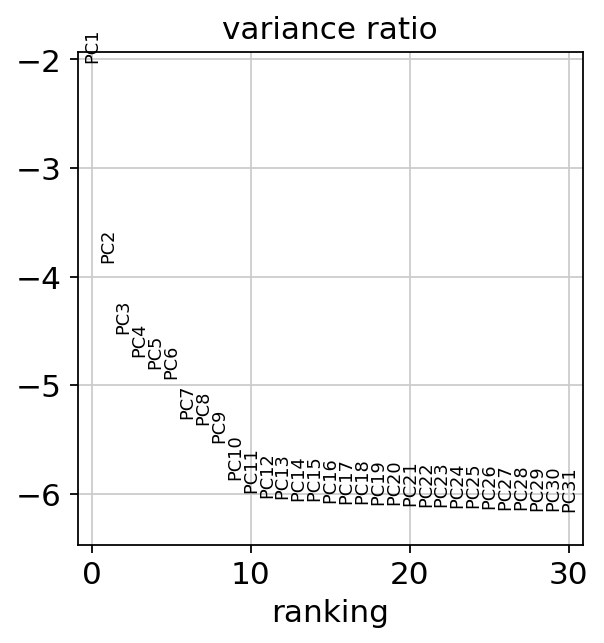

In [39]:
#  variance explained by each principal component
sc.pl.pca_variance_ratio(adata, log=True)

In [40]:
# choosing 30 Pcs as it is the elbow point where the curve actually flattens and then is linear and the first 30 PCs are taken for neighbour graph method

In [41]:
# Building the neighbours graph
import scanpy as sc

# Assuming adata is  AnnData object with raw or normalized counts

# Step 1: Compute the neighbors graph
sc.pp.neighbors(
    adata,
    n_neighbors=15,   # number of neighbors for each cell (common default: 10-30)
    n_pcs=30,         # number of PCs to use
    metric='euclidean'  # distance metric (euclidean is standard)
)


In [42]:
# Inspecting the connectivity matrix
print(adata.obsp['distances'].shape)
print(adata.obsp['connectivities'].shape)
# 2811 cells , Each cell is connected to ~15 neighbors ,Stored inside a 2811 × 2811 sparse graph
#The (2811, 2811) shape indicates that my dataset contains 2811 cells. The distances and connectivities matrices are cell–cell graphs stored in sparse form, where each cell is connected only to its nearest neighbors, and the graph is symmetric


(2811, 2811)
(2811, 2811)


In [43]:
# Leiden CLustering
# Perform Leiden clustering on the neighbors graph
# This uses the graph stored in adata.obsp['connectivities']
# Each node = cell, edges = neighbor relationships

sc.tl.leiden(
    adata,
    resolution=1.0  # Controls cluster granularity:
                    # lower = fewer, larger clusters
                    # higher = more, smaller clusters
)




/tmp/ipython-input-3956937024.py:6: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(


In [44]:
# Perform Leiden clustering on the k-nearest neighbor (kNN) graph
# Each node represents a cell, and edges represent similarity between cells
# The graph is taken from adata.obsp['connectivities']

sc.tl.leiden(
    adata,
    resolution=1.0,      # Controls cluster granularity:
                          # lower values → fewer, larger clusters (broad cell types)
                          # higher values → more, smaller clusters (subtypes / fine structure)

    flavor='igraph',     # Use the igraph backend for Leiden clustering
                          # This implementation is much faster and will be the future default in Scanpy

    n_iterations=2,      # Number of refinement iterations for the Leiden algorithm
                          # 2 is the recommended default (fast and stable)

    directed=False       # Treat the neighbors graph as undirected
                          # Cell–cell similarity graphs in scRNA-seq are symmetric
)




In [45]:
# Number of cells in each Leiden cluster
adata.obs['leiden'].value_counts()
# total 15 clusters , 2811 cells in total is given in the table , and the clusters are not ranked like 0 is not domainatn than 6 etc
# largest cluster -474 , 17 % of the dataset , there is no excessive single cell cluste , smallest is 24

,count
leiden,
0,474
6,304
10,291
2,257
3,240
8,210
1,210
7,179
4,158


In [46]:
# UMAP visualization
# Compute UMAP embedding
# UMAP uses the kNN graph (same one used by Leiden)
# This step creates 2D coordinates for each cell

sc.tl.umap(adata)


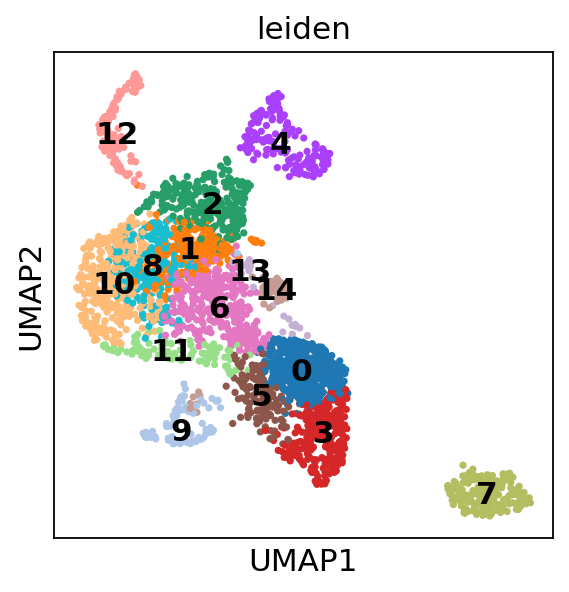

In [47]:
# Plot UMAP colored by Leiden clusters
# Each dot represents a single cell
# Cells close together are transcriptionally similar

sc.pl.umap(
    adata,
    color='leiden',
    legend_loc='on data'
)
# Overlap on UMAP indicates transcriptionally related or transitional cell populations. Since UMAP is a 2D projection of high-dimensional space, some overlap is expected and does not invalidate the clustering

In [48]:
# t-SNE Visuaization
# Compute t-SNE embedding
# t-SNE focuses on preserving local neighborhoods
# It uses the same PCA representation (not raw counts)

sc.tl.tsne(
    adata,
    n_pcs=30  # same number of PCs used for neighbors
)


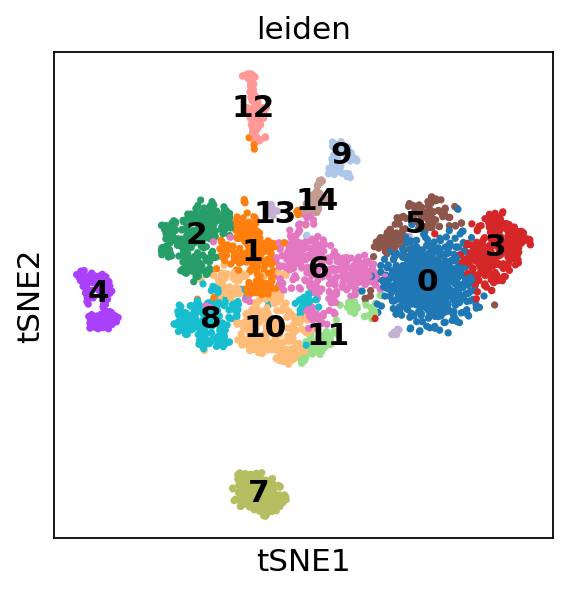

In [49]:
# Visualization of clusters
# Plot t-SNE colored by Leiden clusters
# Expect tighter local clusters but distorted global geometry

sc.pl.tsne(
    adata,
    color='leiden',
    legend_loc='on data'
)
# t-SNE emphasizes local similarity and therefore tends to compress related clusters together, increasing overlap, whereas UMAP preserves both local neighborhoods and broader structure, resulting in clearer separation of related populations.

In [50]:
# Identify marker genes for each Leiden cluster
# This compares each cluster against all other cells
# Wilcoxon test is non-parametric and well suited for scRNA-seq

sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',   # use Leiden clusters
    method='wilcoxon'
)


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:480: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:480: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [51]:
# Checking that the results exist
adata.uns['rank_genes_groups'].keys()


dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

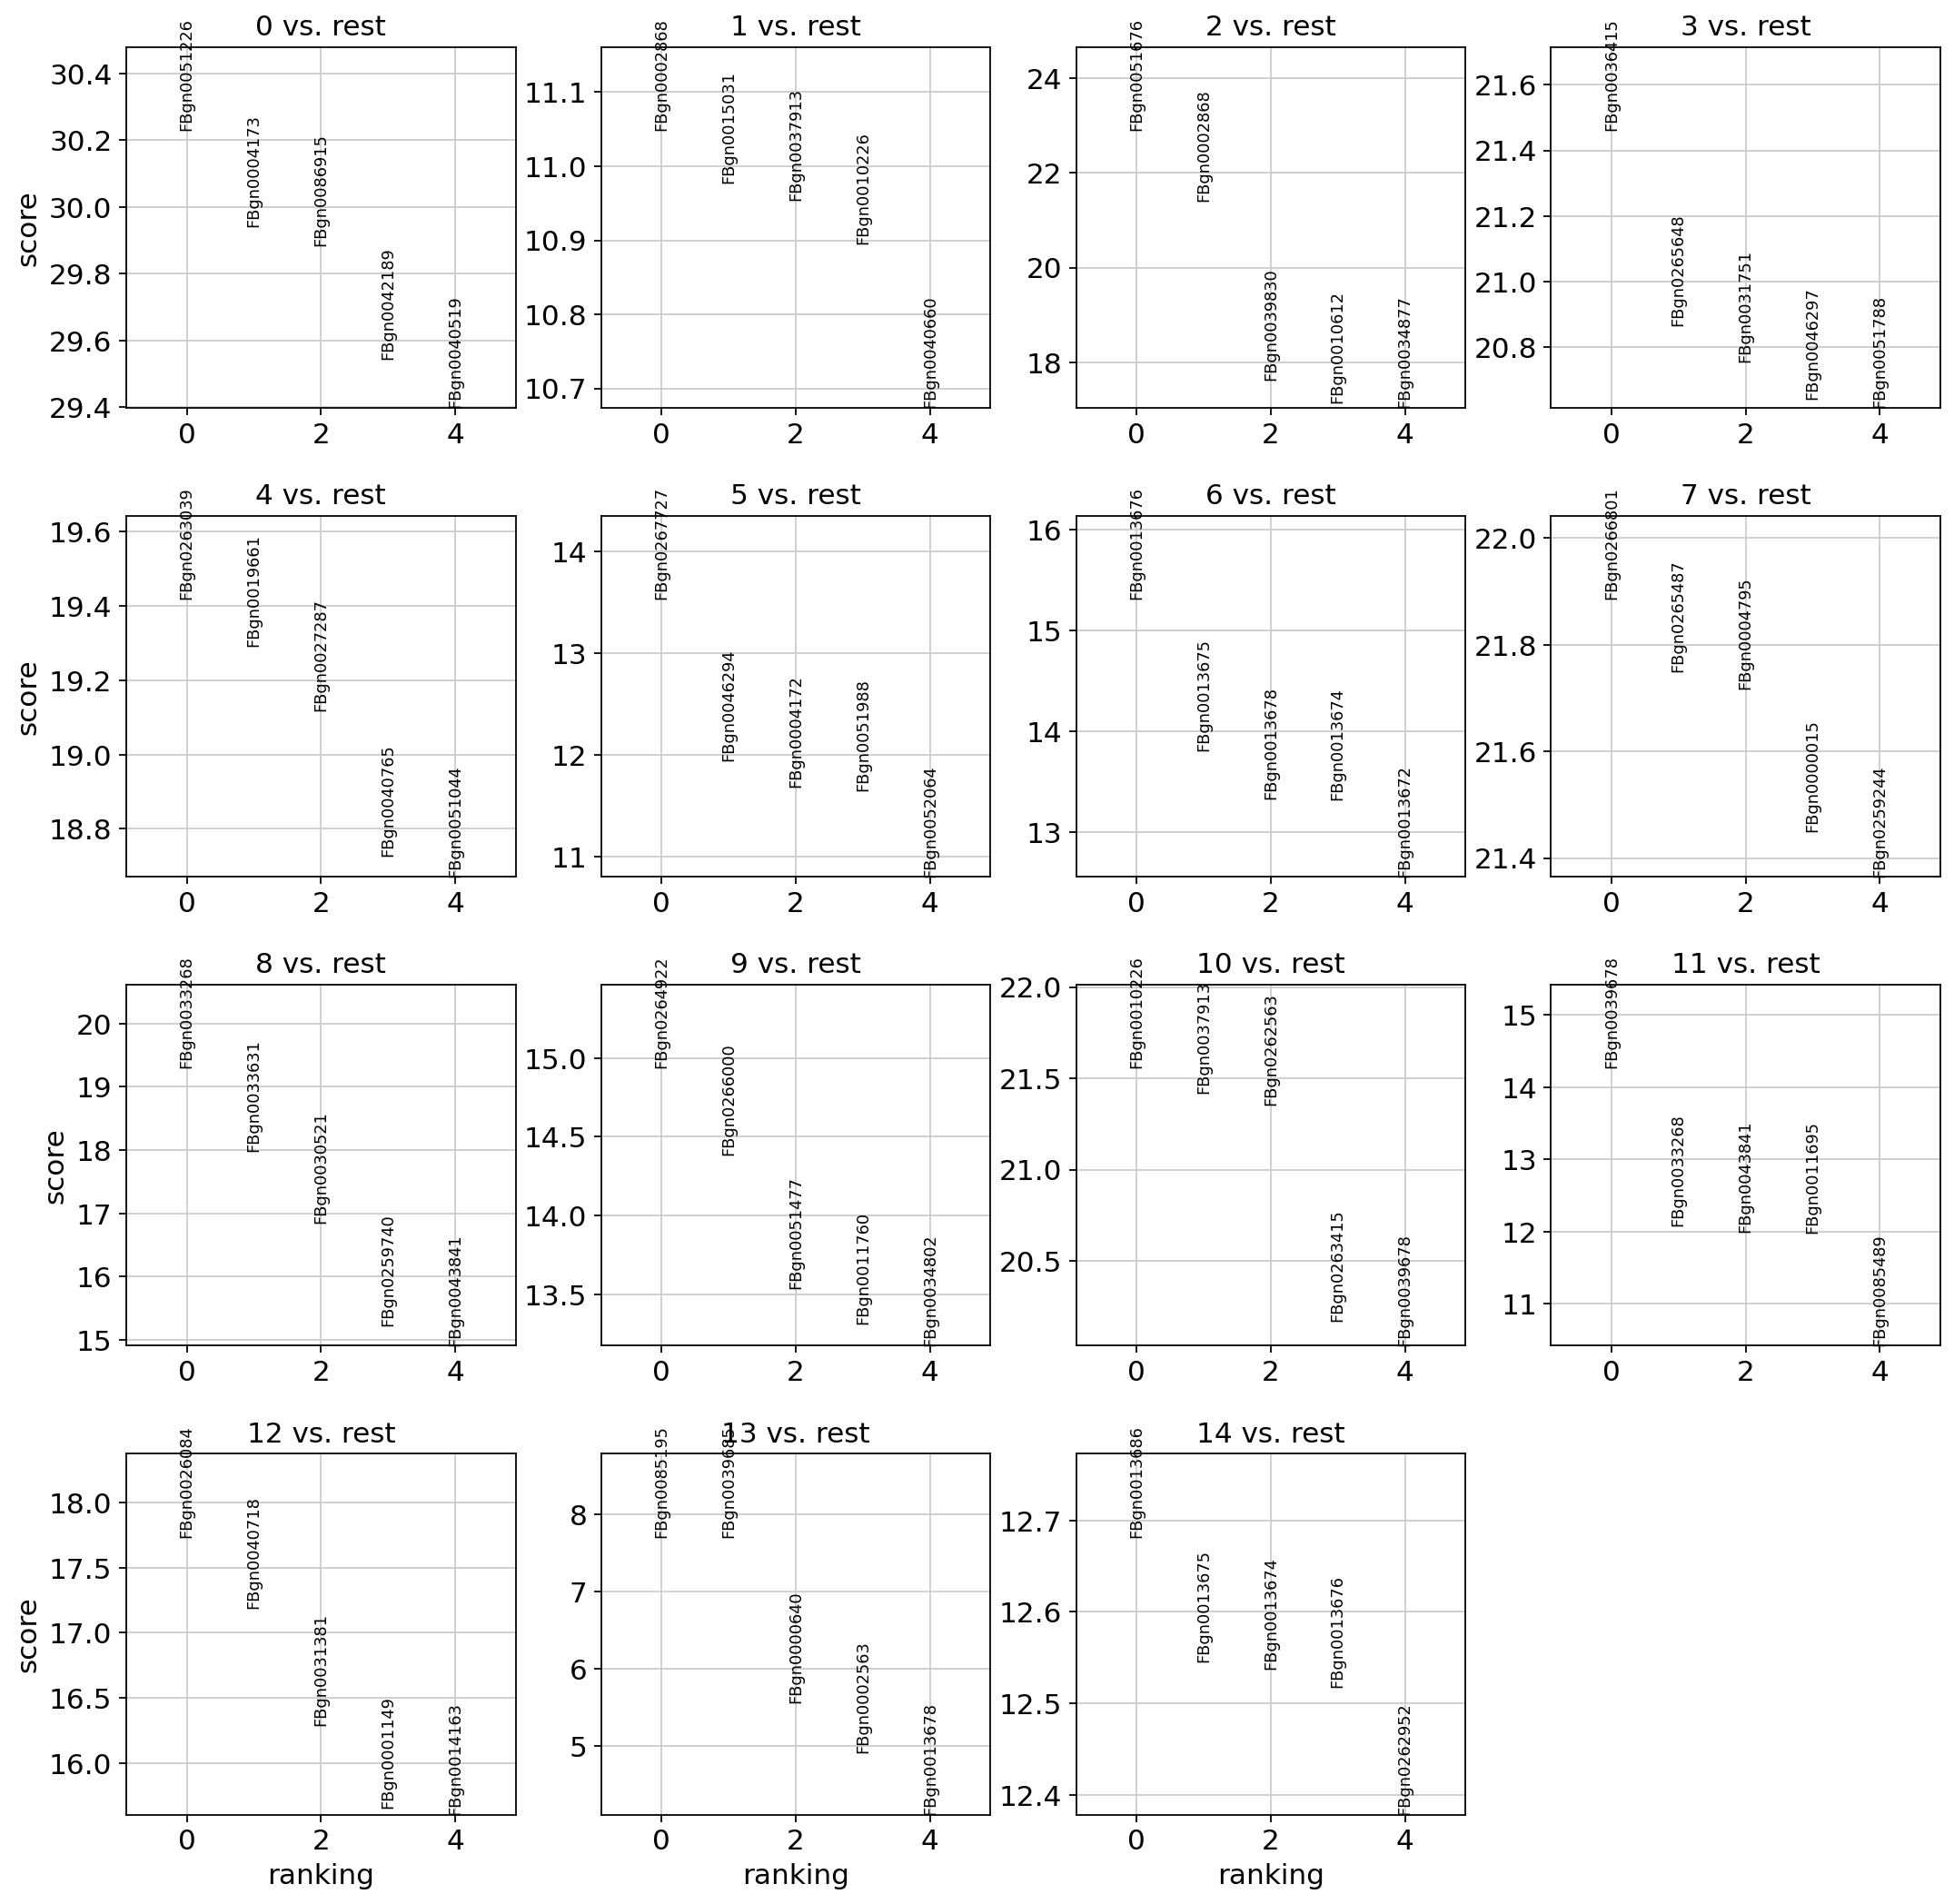

In [52]:
# Show the top 5 marker genes for each Leiden cluster
# This is a ranked list based on Wilcoxon score
sc.pl.rank_genes_groups(
    adata,
    n_genes=5,       # number of top genes per cluster
    sharey=False     # separate y-axis for each cluster for clarity
)


In [53]:
# Make a table and Extract marker genes into a pandas DataFrame
# This is useful for inspection, saving, or annotation
markers = sc.get.rank_genes_groups_df(
    adata,
    group=None       # None = return markers for ALL clusters
)


In [54]:
# Display the full marker table
markers


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,FBgn0051226,30.229244,223.599121,9.779778e-201,1.170542e-196
1,0,FBgn0004173,29.939699,183.551041,5.991779e-197,3.585780e-193
2,0,FBgn0086915,29.884056,123.815895,3.171047e-196,1.265142e-192
3,0,FBgn0042189,29.543211,124.226250,8.027517e-192,2.402034e-188
4,0,FBgn0040519,29.398191,112.468338,5.792005e-190,1.386490e-186
...,...,...,...,...,...,...
179530,14,FBgn0010265,-7.916285,-39.520607,2.447125e-15,1.952643e-12
179531,14,FBgn0003274,-7.995866,-41.544312,1.286662e-15,1.100004e-12
179532,14,FBgn0261599,-8.587860,-49.329720,8.860427e-18,8.157727e-15
179533,14,FBgn0066084,-9.733263,-97.489258,2.175026e-22,2.169407e-19


In [55]:
# Save full marker table to CSV
markers.to_csv(
    "full_marker_table_drosophila.csv",
    index=False
)

# Download to your computer
from google.colab import files
files.download("full_marker_table_drosophila.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# Getting the top marker gene for each cluster - 15 marker gene for 15 clusters
markers_sorted = markers.sort_values('pvals_adj')

In [57]:
# For each Leiden cluster, take the TOP (most significant) marker gene
top_marker_per_cluster = (
    markers_sorted
    .groupby('group')
    .head(1)
)

/tmp/ipython-input-1691401673.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('group')


In [58]:
# View the result
top_marker_per_cluster

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,FBgn0051226,30.229244,223.599121,9.779778e-201,1.170542e-196
23938,2,FBgn0051676,22.891953,68.434235,5.588254e-116,6.688582e-112
83783,7,FBgn0266801,21.885115,38.935257,3.601108e-106,4.310166e-102
119690,10,FBgn0010226,21.555325,150.104095,4.719490e-103,5.648758e-99
35907,3,FBgn0036415,21.460730,48.719276,3.625728e-102,4.339634e-98
47876,4,FBgn0263039,19.417561,18.086666,5.483262e-84,6.562916e-80
95752,8,FBgn0033268,19.293947,354.915375,6.038341e-83,7.227290e-79
143628,12,FBgn0026084,17.733570,93.522484,2.308997e-70,2.763639e-66
71814,6,FBgn0013676,15.305716,278.641174,7.002797e-53,8.381647e-49
107721,9,FBgn0264922,14.934986,78.035347,1.951160e-50,2.335344e-46


In [59]:
# cleaning the table , keeping only 4 important columns
# Keep only the most useful columns
top_marker_per_cluster = top_marker_per_cluster[
    ['group', 'names', 'logfoldchanges', 'pvals_adj']
]

top_marker_per_cluster


,group,names,logfoldchanges,pvals_adj
0,0,FBgn0051226,223.599121,1.170542e-196
23938,2,FBgn0051676,68.434235,6.688582e-112
83783,7,FBgn0266801,38.935257,4.310166e-102
119690,10,FBgn0010226,150.104095,5.648758e-99
35907,3,FBgn0036415,48.719276,4.339634e-98
47876,4,FBgn0263039,18.086666,6.562916e-80
95752,8,FBgn0033268,354.915375,7.227290e-79
143628,12,FBgn0026084,93.522484,2.763639e-66
71814,6,FBgn0013676,278.641174,8.381647e-49
107721,9,FBgn0264922,78.035347,2.335344e-46


In [60]:
# Save top markers to a CSV file
top_marker_per_cluster.to_csv(
    "top_marker_gene_per_leiden_cluster.csv",
    index=False
)


In [61]:
# downloading it
from google.colab import files

files.download("top_marker_gene_per_leiden_cluster.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
# Take top 10 genes per Leiden cluster based on adjusted p-value
top10_per_cluster = (
    markers
    .sort_values(["group", "pvals_adj"])  # best markers first
    .groupby("group")
    .head(10)
    .reset_index(drop=True)
)

top10_per_cluster


/tmp/ipython-input-3018094254.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,FBgn0051226,30.229244,223.599121,9.779778e-201,1.170542e-196
1,0,FBgn0004173,29.939699,183.551041,5.991779e-197,3.585780e-193
2,0,FBgn0086915,29.884056,123.815895,3.171047e-196,1.265142e-192
3,0,FBgn0042189,29.543211,124.226250,8.027517e-192,2.402034e-188
4,0,FBgn0040519,29.398191,112.468338,5.792005e-190,1.386490e-186
...,...,...,...,...,...,...
145,14,FBgn0013678,12.354450,624.133118,4.608951e-35,9.194088e-32
146,14,FBgn0013672,12.060408,608.157532,1.709346e-33,2.922737e-30
147,14,FBgn0013684,11.403385,45.331249,4.021705e-30,6.016973e-27
148,14,FBgn0013679,11.273661,69.328255,1.770527e-29,2.354604e-26


In [63]:
top10_per_cluster = top10_per_cluster[
    ["group", "names", "logfoldchanges", "pvals_adj"]
]

top10_per_cluster


,group,names,logfoldchanges,pvals_adj
0,0,FBgn0051226,223.599121,1.170542e-196
1,0,FBgn0004173,183.551041,3.585780e-193
2,0,FBgn0086915,123.815895,1.265142e-192
3,0,FBgn0042189,124.226250,2.402034e-188
4,0,FBgn0040519,112.468338,1.386490e-186
...,...,...,...,...
145,14,FBgn0013678,624.133118,9.194088e-32
146,14,FBgn0013672,608.157532,2.922737e-30
147,14,FBgn0013684,45.331249,6.016973e-27
148,14,FBgn0013679,69.328255,2.354604e-26


In [64]:
csv_path = "top10_marker_genes_per_leiden_cluster.csv"
top10_per_cluster.to_csv(csv_path, index=False)

print(f"Saved file as {csv_path}")


Saved file as top10_marker_genes_per_leiden_cluster.csv


In [65]:
from google.colab import files
files.download(csv_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [66]:
# Annotating Clusters using clusters across a few genes
# looking at the top 3 genes , what kind of cell they are known for
#if 2-3 genes agree we annotate the cluster and move to the next cluster

In [67]:
# Let us take cluster 4
top10_per_cluster[top10_per_cluster['group'] == '4']
# FBgn0263039 - IncRNA gene
# FBgn0019661 - long non-coding RNA gene
# FBgn0027287 - protein coding gene

,group,names,logfoldchanges,pvals_adj
40,4,FBgn0263039,18.086666,6.562916e-80
41,4,FBgn0019661,51.429325,3.763819e-79
42,4,FBgn0027287,23.881836,7.317575e-78
43,4,FBgn0040765,53.188637,9.076335e-75
44,4,FBgn0051044,18.924850,2.034305e-74
45,4,FBgn0039350,9.205653,6.323161e-73
46,4,FBgn0028371,8.890242,1.220407e-69
47,4,FBgn0019660,14.477358,1.554192e-69
48,4,FBgn0040752,27.762417,2.526347e-69
49,4,FBgn0003345,9.480078,9.777664e-68


In [68]:
# cluster 5
top10_per_cluster[top10_per_cluster['group'] == '5']
# FBgn0267727	- protein coding
# FBgn0046294 - protein coding
# FBgn0004172	- protein coding

,group,names,logfoldchanges,pvals_adj
50,5,FBgn0267727,65.833641,1.287625e-37
51,5,FBgn0046294,48.129452,4.687097e-29
52,5,FBgn0004172,56.637573,6.385082e-28
53,5,FBgn0051988,39.376312,7.575319e-28
54,5,FBgn0034138,-41.382572,5.388837e-27
55,5,FBgn0023170,-78.698479,8.416095e-27
56,5,FBgn0267910,-452.897491,9.096715e-27
57,5,FBgn0066084,-81.996567,5.200671e-26
58,5,FBgn0086472,-49.093662,5.656048e-26
59,5,FBgn0016726,-35.799961,1.093597e-24


In [69]:
# cluster 0
top10_per_cluster[top10_per_cluster['group'] == '0']
#FBgn0051226	- protein coding
# FBgn0004173 - protein coding
# FBgn0086915- protein coding

,group,names,logfoldchanges,pvals_adj
0,0,FBgn0051226,223.599121,1.170542e-196
1,0,FBgn0004173,183.551041,3.585780e-193
2,0,FBgn0086915,123.815895,1.265142e-192
3,0,FBgn0042189,124.226250,2.402034e-188
4,0,FBgn0040519,112.468338,1.386490e-186
5,0,FBgn0001281,68.442993,2.985315e-170
6,0,FBgn0267726,68.402725,1.388951e-166
7,0,FBgn0085197,79.441940,1.675773e-165
8,0,FBgn0047351,64.530830,2.664388e-164
9,0,FBgn0050430,82.754463,4.012815e-164


In [70]:
# cluster 1
top10_per_cluster[top10_per_cluster['group'] == '1']
# FBgn0004173 - protein coding
# FBgn0040519 - protein coding
# FBgn0051226	- protein coding


,group,names,logfoldchanges,pvals_adj
10,1,FBgn0004173,-70.817947,2.740778e-28
11,1,FBgn0040519,-44.227097,6.174234e-27
12,1,FBgn0051226,-86.953278,6.556119e-27
13,1,FBgn0050430,-34.342915,7.642059e-27
14,1,FBgn0041102,-30.633301,1.790063e-26
15,1,FBgn0267727,-21.374693,7.166323e-26
16,1,FBgn0002868,47.968849,3.819560e-25
17,1,FBgn0085197,-34.103439,3.971932e-25
18,1,FBgn0015031,32.464840,6.535910e-25
19,1,FBgn0037913,33.311195,7.591270e-25


In [71]:
# cluster 2 -
top10_per_cluster[top10_per_cluster['group'] == '2']
# FBgn0051676 - protein coding
# FBgn0002868 - protein coding
# FBgn0039830	- protein coding

,group,names,logfoldchanges,pvals_adj
20,2,FBgn0051676,68.434235,6.688582e-112
21,2,FBgn0002868,133.594803,7.895682e-98
22,2,FBgn0039830,46.518135,5.849446e-66
23,2,FBgn0010612,37.420452,2.437334e-62
24,2,FBgn0034877,34.951077,9.985595e-62
25,2,FBgn0265413,24.734035,4.385369e-61
26,2,FBgn0040793,42.021454,1.086159e-60
27,2,FBgn0003360,33.771976,3.125683e-60
28,2,FBgn0035032,34.738396,2.454516e-58
29,2,FBgn0031066,30.129147,2.440853e-55


In [72]:
# for cluster 3
top10_per_cluster[top10_per_cluster['group'] == '3']
# FBgn0036415 - protein coding
# FBgn0265648	- Inc RNA gene
# FBgn0031751 - protein coding

,group,names,logfoldchanges,pvals_adj
30,3,FBgn0036415,48.719276,4.339634e-98
31,3,FBgn0265648,29.576876,6.569088e-93
32,3,FBgn0031751,35.854988,4.441010e-92
33,3,FBgn0267910,-542.937439,8.490759e-92
34,3,FBgn0046297,35.752831,2.849392e-91
35,3,FBgn0051788,59.366947,4.035921e-91
36,3,FBgn0053340,37.321934,1.209522e-90
37,3,FBgn0051709,27.720695,5.727417e-90
38,3,FBgn0267727,47.761192,4.819861e-88
39,3,FBgn0038225,18.925261,5.231587e-88


In [73]:
# for cluster 6
top10_per_cluster[top10_per_cluster['group'] == '6']
#FBgn0013676	- protein coding
# FBgn0013675 - protein coding
# FBgn0013674 - protein coding


,group,names,logfoldchanges,pvals_adj
60,6,FBgn0013676,278.641174,8.381647e-49
61,6,FBgn0013675,134.395523,1.454612e-39
62,6,FBgn0013678,96.342911,5.190347e-37
63,6,FBgn0013674,181.088776,5.190347e-37
64,6,FBgn0013672,61.476936,8.819136e-33
65,6,FBgn0013686,53.450958,7.475372e-29
66,6,FBgn0033268,79.664238,9.357378e-21
67,6,FBgn0262952,23.236082,1.624957e-18
68,6,FBgn0010226,36.462944,6.831282e-17
69,6,FBgn0250823,-4.576664,1.010414e-14


In [74]:
# for cluster 7
top10_per_cluster[top10_per_cluster['group'] == '7']
# FBgn0266801	- protein coding gene
# FBgn0265487- protein coding gene
# FBgn0004795 - protein coding gene

,group,names,logfoldchanges,pvals_adj
70,7,FBgn0266801,38.935257,4.310166e-102
71,7,FBgn0265487,33.415859,4.280984e-101
72,7,FBgn0004795,27.470678,5.732662e-101
73,7,FBgn0000015,21.694666,1.372518e-98
74,7,FBgn0259244,39.745689,6.792587e-98
75,7,FBgn0010113,51.581089,1.764067e-97
76,7,FBgn0015541,24.266422,1.957282e-97
77,7,FBgn0015229,25.415236,6.678082e-96
78,7,FBgn0002592,32.204613,1.901726e-95
79,7,FBgn0050069,15.423314,4.837356e-95


In [75]:
# for cluster 8
top10_per_cluster[top10_per_cluster['group'] == '8']
# FBgn0033268	- protein coding gene
# FBgn0033631 - protein coding gene
# FBgn0030521 - protein coding gene


,group,names,logfoldchanges,pvals_adj
80,8,FBgn0033268,354.915375,7.227290e-79
81,8,FBgn0033631,31.031706,1.902124e-68
82,8,FBgn0030521,29.705109,4.830795e-60
83,8,FBgn0259740,29.124790,7.414792e-49
84,8,FBgn0043841,36.532692,6.817127e-47
85,8,FBgn0013770,23.994156,2.437947e-42
86,8,FBgn0023170,85.548264,3.484624e-42
87,8,FBgn0001090,14.185217,2.792738e-40
88,8,FBgn0066084,82.993721,2.872486e-39
89,8,FBgn0035969,9.682885,4.027199e-39


In [76]:
# for cluster 9 -
top10_per_cluster[top10_per_cluster['group'] == '9']
# FBgn0264922 - protein coding gene
# FBgn0266000 - protein coding gene
# FBgn0051477	- protein coding gene

,group,names,logfoldchanges,pvals_adj
90,9,FBgn0264922,78.035347,2.335344e-46
91,9,FBgn0266000,71.125893,4.078401e-43
92,9,FBgn0051477,24.188677,3.823489e-38
93,9,FBgn0011760,45.491886,6.157450e-37
94,9,FBgn0034802,44.341576,2.958969e-36
95,9,FBgn0038277,27.532452,2.167795e-35
96,9,FBgn0039129,19.378832,1.303159e-33
97,9,FBgn0031296,14.723485,4.541978e-32
98,9,FBgn0001233,43.975819,1.024383e-31
99,9,FBgn0262104,14.402606,1.024383e-31


In [77]:
# for cluster 10 -
top10_per_cluster[top10_per_cluster['group'] == '10']
# FBgn0010226 - protein coding gene
# FBgn0037913 - protein coding gene
# FBgn0262563 - protein coding gene


,group,names,logfoldchanges,pvals_adj
100,10,FBgn0010226,150.104095,5.648758e-99
101,10,FBgn0037913,64.680946,5.632014e-98
102,10,FBgn0262563,31.847580,1.450119e-97
103,10,FBgn0263415,38.266552,5.358858e-87
104,10,FBgn0039678,175.693222,6.519525e-86
105,10,FBgn0063497,30.234314,3.446493e-80
106,10,FBgn0001224,50.523006,4.115708e-77
107,10,FBgn0033268,203.241318,2.950827e-75
108,10,FBgn0040773,39.745361,2.764861e-64
109,10,FBgn0038198,12.970241,1.818455e-63


In [78]:
# for cluster 11
top10_per_cluster[top10_per_cluster['group'] == '11' ]
# FBgn0039678 - protein coding gene
# FBgn0033268 -  protein coding gene
# FBgn0043841 -  protein coding gene

,group,names,logfoldchanges,pvals_adj
110,11,FBgn0039678,402.747162,4.429717e-42
111,11,FBgn0033268,322.550049,8.525894e-30
112,11,FBgn0043841,42.739632,1.381216e-29
113,11,FBgn0011695,24.670345,1.381216e-29
114,11,FBgn0085489,22.956350,4.843040e-22
115,11,FBgn0030159,14.836473,5.274480e-22
116,11,FBgn0030160,17.149174,1.481200e-19
117,11,FBgn0085446,31.538029,1.964133e-19
118,11,FBgn0262563,20.822954,2.656913e-19
119,11,FBgn0038149,12.636574,1.742519e-17


In [79]:
# cluster 12 -
top10_per_cluster[top10_per_cluster['group'] == '12']
# FBgn0026084	- protein coding gene
# FBgn0040718 - protein coding gene
# FBgn0031381 - protein coding gene


,group,names,logfoldchanges,pvals_adj
120,12,FBgn0026084,93.522484,2.763639e-66
121,12,FBgn0040718,122.605171,2.118900e-62
122,12,FBgn0031381,69.990448,4.713506e-56
123,12,FBgn0001149,137.179260,9.711838e-52
124,12,FBgn0014163,113.036400,1.626050e-51
125,12,FBgn0034443,41.906784,4.465871e-50
126,12,FBgn0051363,55.698586,1.457634e-48
127,12,FBgn0000042,66.461716,1.837992e-47
128,12,FBgn0038826,36.512814,6.642196e-45
129,12,FBgn0030993,27.182301,8.307810e-45


In [80]:
# for cluster 13 -
top10_per_cluster[top10_per_cluster['group'] == '13']
# FBgn0039685	- protein coding gene
# FBgn0085195	- protein coding gene
# FBgn0000640 - protein coding gene


,group,names,logfoldchanges,pvals_adj
130,13,FBgn0085195,37.126904,7.931487e-11
131,13,FBgn0039685,53.075226,7.931487e-11
132,13,FBgn0000640,20.847242,1.071377e-04
133,13,FBgn0002563,21.245070,2.763906e-03
134,13,FBgn0013678,98.033417,9.406245e-02
135,13,FBgn0002565,19.000603,2.423598e-01
136,13,FBgn0013675,131.765610,4.087105e-01
137,13,FBgn0013674,139.120926,9.976627e-01
138,13,FBgn0013676,172.534882,9.976627e-01
139,13,FBgn0013672,53.584625,9.976627e-01


In [81]:
# for cluster 14
top10_per_cluster[top10_per_cluster['group'] == '14']
# FBgn0013686 - mt_LSU_rRNA_gene
# FBgn0013676 - protein coding gene
# FBgn0013675 - protein coding gene

,group,names,logfoldchanges,pvals_adj
140,14,FBgn0013686,591.316406,8.933760e-33
141,14,FBgn0013675,inf,1.793521e-32
142,14,FBgn0013674,inf,1.793521e-32
143,14,FBgn0013676,inf,1.793521e-32
144,14,FBgn0262952,298.396149,8.180624e-32
145,14,FBgn0013678,624.133118,9.194088e-32
146,14,FBgn0013672,608.157532,2.922737e-30
147,14,FBgn0013684,45.331249,6.016973e-27
148,14,FBgn0013679,69.328255,2.354604e-26
149,14,FBgn0031273,70.425804,9.931512e-22


In [82]:
# Cell type annotation
# four types - High-confidence biological type
# 2️ Putative / functional state
# 3️ Transcriptionally related cluster
# 4️ Low-quality / technical cluster

In [83]:
# Create annotation dictionary
cluster_annotation = {
    '0': 'Common transcriptional state',
    '1': 'Related to cluster 0',
    '2': 'Uncharacterized population',
    '3': 'Transitional / regulatory state',
    '4': 'lncRNA-enriched population',
    '5': 'Uncharacterized population',
    '6': 'Gene-family–specific population',
    '7': 'Distinct uncharacterized population',
    '8': 'Uncharacterized population',
    '9': 'Uncharacterized population',
    '10': 'Uncharacterized population',
    '11': 'Related to cluster 8',
    '12': 'Uncharacterized population',
    '13': 'Uncharacterized population',
    '14': 'Low-quality / mitochondrial cells'
}

# Map to cells
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotation)



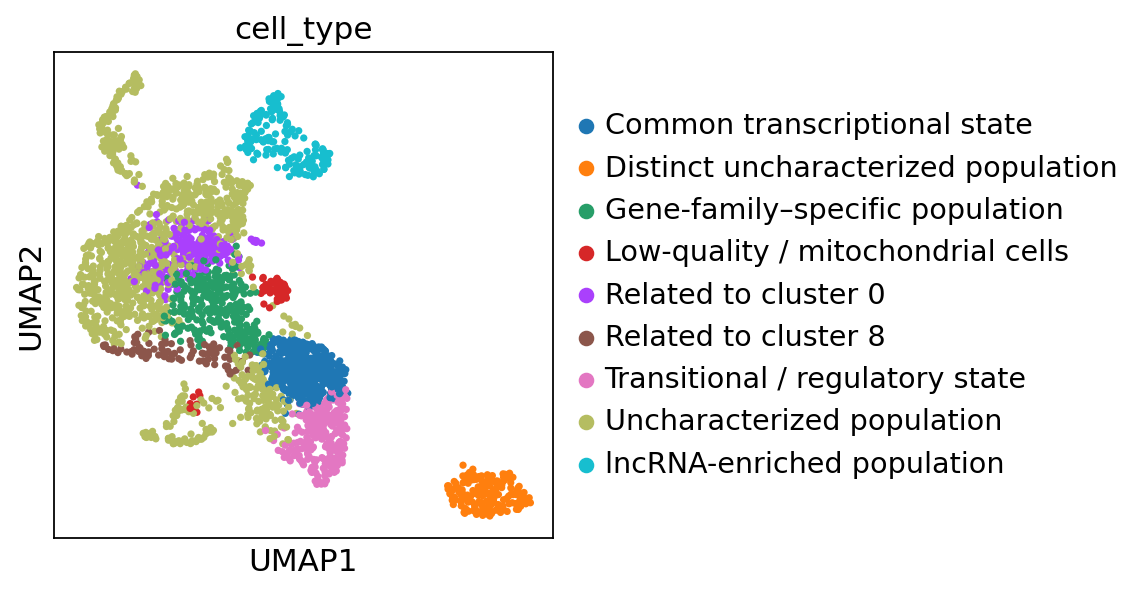

In [84]:
# merging the labels on right
sc.pl.umap(
    adata,
    color='cell_type',
    legend_loc='right margin'
)


In [85]:
# Checking the runtime , RAM Usage , CPU
# Basic system information
import platform
import sys

print("Python version:", sys.version)
print("Platform:", platform.platform())
print("Processor:", platform.processor())
print("Machine:", platform.machine())


Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Processor: x86_64
Machine: x86_64


In [86]:
# CPU Details
!lscpu


Architecture:                x86_64
  CPU op-mode(s):            32-bit, 64-bit
  Address sizes:             46 bits physical, 48 bits virtual
  Byte Order:                Little Endian
CPU(s):                      2
  On-line CPU(s) list:       0,1
Vendor ID:                   GenuineIntel
  Model name:                Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:              6
    Model:                   79
    Thread(s) per core:      2
    Core(s) per socket:      1
    Socket(s):               1
    Stepping:                0
    BogoMIPS:                4399.99
    Flags:                   fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pg
                             e mca cmov pat pse36 clflush mmx fxsr sse sse2 ss h
                             t syscall nx pdpe1gb rdtscp lm constant_tsc rep_goo
                             d nopl xtopology nonstop_tsc cpuid tsc_known_freq p
                             ni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2ap
                   

In [87]:
# RAM
!free -h


               total        used        free      shared  buff/cache   available
Mem:            12Gi       1.7Gi       6.6Gi       3.0Mi       4.4Gi        10Gi
Swap:             0B          0B          0B


In [88]:
# Live RAM usage inside Python
import psutil

process = psutil.Process()
memory_mb = process.memory_info().rss / 1024**2

print(f"Current RAM usage: {memory_mb:.2f} MB")


Current RAM usage: 1504.98 MB


In [89]:
#Runtime was measured for downstream analysis steps as well as standard preprocessing


In [90]:
import time
import scanpy as sc
import pandas as pd

timings = {}

def record(step, func):
    t0 = time.time()
    func()
    t1 = time.time()
    timings[step] = round(t1 - t0, 2)


In [91]:
def load_data():
    global adata

    adata = sc.read_mtx(
        "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.matrix.mtx.gz"
    ).T

    features = pd.read_csv(
        "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.features.tsv.gz",
        sep="\t",
        header=None
    )

    barcodes = pd.read_csv(
        "/content/drive/MyDrive/scanpy_scrna_drosophila/GSM3585574_SV_1_10X_Te.barcodes.tsv.gz",
        sep="\t",
        header=None
    )

    adata.var_names = features[1].values
    adata.obs_names = barcodes[0].values
    adata.var_names_make_unique()

record("Data loading + AnnData creation", load_data)


In [92]:
record(
    "QC metrics computation",
    lambda: (
        adata.var.__setitem__("mt", adata.var_names.str.startswith("mt:")),
        sc.pp.calculate_qc_metrics(
            adata,
            qc_vars=["mt"],
            percent_top=None,
            log1p=False,
            inplace=True
        )
    )
)


In [93]:
record(
    "QC filtering",
    lambda: (
        sc.pp.filter_cells(adata, min_genes=200),
        sc.pp.filter_genes(adata, min_cells=3)
    )
)


In [94]:
record(
    "Library size normalization",
    lambda: sc.pp.normalize_total(adata, target_sum=1e4)
)


In [95]:
record(
    "Log1p transformation",
    lambda: sc.pp.log1p(adata)
)


In [96]:
record(
    "HVG selection",
    lambda: sc.pp.highly_variable_genes(
        adata,
        n_top_genes=2000,
        flavor="seurat",
        inplace=True
    )
)


In [97]:
record(
    "HVG subsetting",
    lambda: globals().update(
        adata=adata[:, adata.var.highly_variable]
    )
)


In [98]:
record(
    "Scaling",
    lambda: sc.pp.scale(adata, max_value=10)
)


/usr/lib/python3.12/functools.py:912: UserWarning: Received a view of an AnnData. Making a copy.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [99]:
record(
    "PCA",
    lambda: sc.tl.pca(adata, svd_solver="arpack")
)


In [100]:
record(
    "Neighbors graph",
    lambda: sc.pp.neighbors(
        adata,
        n_neighbors=15,
        n_pcs=30,
        metric="euclidean"
    )
)


In [101]:
record(
    "Leiden clustering",
    lambda: sc.tl.leiden(
        adata,
        resolution=1.0,
        flavor="igraph",
        n_iterations=2,
        directed=False
    )
)


In [102]:
record(
    "UMAP",
    lambda: sc.tl.umap(adata)
)


In [103]:
record(
    "Marker gene detection (Wilcoxon)",
    lambda: sc.tl.rank_genes_groups(
        adata,
        groupby="leiden",
        method="wilcoxon"
    )
)


/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: 

In [104]:
for step, t in timings.items():
    print(f"{step}: {t} seconds")


Data loading + AnnData creation: 0.83 seconds
QC metrics computation: 0.05 seconds
QC filtering: 0.18 seconds
Library size normalization: 0.06 seconds
Log1p transformation: 0.06 seconds
HVG selection: 0.1 seconds
HVG subsetting: 0.0 seconds
Scaling: 0.07 seconds
PCA: 2.66 seconds
Neighbors graph: 0.11 seconds
Leiden clustering: 0.09 seconds
UMAP: 5.92 seconds
Marker gene detection (Wilcoxon): 6.53 seconds


In [105]:
total_runtime = sum(timings.values())

print(f"Total pipeline runtime: {total_runtime:.2f} seconds")

Total pipeline runtime: 16.66 seconds
